In [1]:
import torch
import torch.nn as nn
import torchvision as vision
from torchvision.transforms import Lambda,Compose,ToTensor,Normalize,Grayscale
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
transform=Compose([Grayscale(),ToTensor(),Normalize(0.5,0.5)])
dataset_train=datasets.ImageFolder("/kaggle/input/fer2013/train",transform=transform)
dataset_test=datasets.ImageFolder("/kaggle/input/fer2013/test",transform=transform)


In [3]:
print("There are {} samples each with the following categories \n {}".format(
      len(dataset_train),dataset_train.classes))

There are 28709 samples each with the following categories 
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
itr=iter(dataset_train)
img,label=next(itr)
img.size()

torch.Size([1, 48, 48])

In [5]:
train_loader=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset_test,batch_size=128,shuffle=False,num_workers=2)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.drop1=nn.Dropout()
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.drop2=nn.Dropout()
        self.fc1=nn.Linear(in_features=9*9*256,out_features=1024)
        self.drop3=nn.Dropout()
        self.fc2=nn.Linear(in_features=1024,out_features=7)
    def forward(self,x):
        #input (1,48,48)
        x=self.conv1(x)
        x=self.relu(x)
        #input (32,46,46)
        x=self.conv2(x)
        x=self.relu(x)
        #input (64,44,44)
        x=self.pool1(x)
        x=self.drop1(x)
        
        #input (64,22,22)
        x=self.conv3(x)
        x=self.relu(x)
        #input (128,20,20)
        x=self.conv4(x)
        x=self.relu(x)
        #input (256,18,18)
        x=self.pool2(x)
        x=self.drop2(x)
        #input (256,9,9)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drop3(x)
        x=self.fc2(x)
        return x

In [7]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
model=Net()
model=model.cuda()
model.apply(init_weights)

Net(
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=20736, out_features=1024, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)

In [8]:
%%time
import torch.optim as optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())
from tqdm import tqdm
epochs=10

for epoch in range(epochs):
    print(f"epoch {epoch}:",end=' ')
    train_loader=tqdm(train_loader)
    epoch_loss=0.0
    for imgs,labels in train_loader:
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(epoch_loss)
    
        

epoch 0: 

100%|██████████| 449/449 [01:10<00:00,  6.40it/s]


744.6403611898422
epoch 1: 

100%|██████████| 449/449 [00:19<00:00, 22.55it/s]


618.6975874900818
epoch 2: 

100%|██████████| 449/449 [00:20<00:00, 22.10it/s]


571.1807827353477
epoch 3: 

100%|██████████| 449/449 [00:20<00:00, 21.80it/s]


542.5317810177803
epoch 4: 

100%|██████████| 449/449 [00:19<00:00, 22.53it/s]


520.7870004177094
epoch 5: 

100%|██████████| 449/449 [00:20<00:00, 22.32it/s]


497.53254705667496
epoch 6: 

100%|██████████| 449/449 [00:19<00:00, 22.49it/s]


480.7782652974129
epoch 7: 

100%|██████████| 449/449 [00:19<00:00, 22.64it/s]


462.77830070257187
epoch 8: 

100%|██████████| 449/449 [00:20<00:00, 22.17it/s]


445.3404230475426
epoch 9: 

100%|██████████| 449/449 [00:20<00:00, 22.32it/s]

428.14560401439667
CPU times: user 1min 15s, sys: 7.46 s, total: 1min 22s
Wall time: 4min 11s


In [9]:
# save the model to a file
torch.save(model,'model.h5')

In [10]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=7)
conmat=conmat.cuda()

In [11]:
# load the model from the file
model=torch.load('model.h5')
total=len(dataset_test)
correct=0
for imgs,labels in test_loader:
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,predicted=torch.max(outputs.data,1)
    tmp=(predicted==labels).sum()
    correct+=tmp
    conmat.update(predicted,labels)
print(correct/total)

tensor(0.5403, device='cuda:0')


In [12]:
import matplotlib.pyplot as plt
import seaborn as sb

<AxesSubplot:>

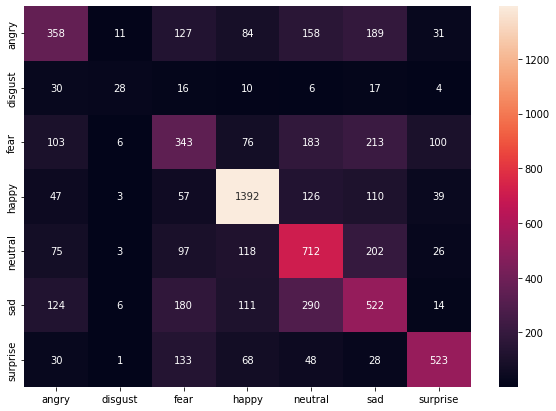

In [13]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")